# Task

Predict the rating a user will give a product.

# Importing Libraries & Data

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm

In [10]:
# Importing Data
products = pd.read_csv("archive/product_info.csv")
reviews = pd.read_csv("archive/reviews_0-250.csv",index_col=0) # only using first 100_000 rows of reviews

/var/folders/h9/4qqztth57ws20mrrtmbdg_500000gp/T/ipykernel_22597/2014431244.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.read_csv("archive/reviews_0-250.csv",index_col=0) # only using first 100_000 rows of reviews


In [11]:
print(products.shape)
print(reviews.shape)

(8494, 27)
(602130, 18)


In [12]:
reviews.columns

Index(['author_id', 'rating', 'is_recommended', 'helpfulness',
       'total_feedback_count', 'total_neg_feedback_count',
       'total_pos_feedback_count', 'submission_time', 'review_text',
       'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color',
       'product_id', 'product_name', 'brand_name', 'price_usd'],
      dtype='object')

# Exploratory Data Analysis

In [13]:
# Querying for necessary columns
products = products[['product_id','brand_id','loves_count','rating','reviews','price_usd','primary_category']]
reviews = reviews[['author_id','product_id','rating','is_recommended','helpfulness','submission_time','review_text','review_title']]

In [14]:
# Percentages of null data 

In [15]:
reviews.isnull().sum() / reviews.shape[0]

author_id          0.000000
product_id         0.000000
rating             0.000000
is_recommended     0.195117
helpfulness        0.551097
submission_time    0.000000
review_text        0.001659
review_title       0.277367
dtype: float64

In [20]:
products.isnull().sum() / products.shape[0]

product_id          0.000000
brand_id            0.000000
loves_count         0.000000
rating              0.032729
reviews             0.032729
price_usd           0.000000
primary_category    0.000000
dtype: float64

In [21]:
# Distributions of key features

In [22]:
products['rating'].value_counts() 

5.0000    256
4.0000    174
4.5000     82
4.3333     68
3.0000     66
         ... 
4.6954      1
4.2841      1
4.3613      1
4.6878      1
4.6367      1
Name: rating, Length: 4394, dtype: int64

Text(0.5, 1.0, 'Histogram of Ratings')

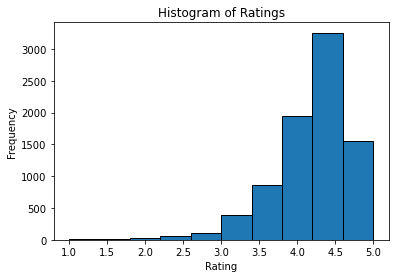

In [27]:
# Plotting the histogram
plt.hist(products['rating'], edgecolor='black')

# Adding labels and title
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Ratings')

Ratings are skewed to being more positive

# Baseline Models

A simple model we can implement is to predict that a user will give a product its already average rating.

In [28]:
itemAvg = products.set_index('product_id')['rating'].to_dict()
globalAvg = products['rating'].mean()
globalAvg

4.194512889483925

In [29]:
def avgRating(product_id):
    if product_id not in itemAvg: # return globalAvg if product has not been seen before
        return [globalAvg]
    return [itemAvg[product_id]]

In [30]:
# Predicting ratings
y = np.array(reviews.rating)
y_pred = reviews.product_id.apply(avgRating).to_list()

In [31]:
# Model Evaluation
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print(f'MSE:{mse}')
print(f'RMSE:{rmse}') 

MSE:1.258782907660306
RMSE:1.121954949033296


This model's predictions are off by about 1.12. Since rating go from a scale from 1 - 5 this model performs pretty bad being off by 1.12 is pretty bad.

Another model we can exlore is to determine the deviations each user has in their personal ratings and the deviations each item has compared to the global averages. 

In [32]:
# Create training and test set for reviews 
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(reviews, test_size=0.2, random_state=42)

In [33]:
# Splitting data and maintaining distribution of ratings in training and test set
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 

for train_index, test_index in split.split(reviews, reviews["rating"]):
        strat_train_set = reviews.loc[train_index]
        strat_test_set = reviews.loc[test_index]

In [34]:
reviews.rating.value_counts() / len(reviews)

5    0.646040
4    0.177629
3    0.073104
1    0.054644
2    0.048583
Name: rating, dtype: float64

In [35]:
strat_train_set.rating.value_counts() / len(strat_train_set)

5    0.646040
4    0.177630
3    0.073105
1    0.054644
2    0.048582
Name: rating, dtype: float64

In [36]:
# Creating Model

In [37]:
# Functions for the model 

# Create feature vector
def features(datum, alpha, betaU, betaI):
    user = datum.author_id
    item = datum.product_id
    
    # logic for users or items not seen in the training set
    if user in betaU:
        bu = betaU[user]
    else:
        bu = 0
        
    if item in betaI:
        bi = betaI[item]
    else:
        bi = 0
        
    return [alpha, bu, bi]

def predict_rating(datum):
    a = datum[0]
    bu = datum[1]
    bi = datum[2]
    return a + bu + bi

In [45]:
ratingsPerUser = strat_train_set.groupby('author_id')['rating'].count().to_dict()
ratingsPerItem = strat_train_set.groupby('product_id')['rating'].count().to_dict()

userAvg = strat_train_set.groupby('author_id')['rating'].mean().to_dict()
products = products.dropna(subset=['rating'])
itemAvg = products.set_index('product_id')['rating'].to_dict()
ratingMean = sum(itemAvg.values()) / len(itemAvg)
ratingMean # based on avg product reviews

4.194512889483925


In [47]:
ratingDict = {}
for index, review in strat_train_set.iterrows():
    user_id = review['author_id']
    item_id = review['product_id']
    rating = float(review['rating'])

    ratingDict[(user_id, item_id)] = rating

In [48]:
from collections import defaultdict

usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)
reviewsPerUser = defaultdict(list)

for index, review in strat_train_set.iterrows():
    user_id = review['author_id']
    item_id = review['product_id']
    rating = float(review['rating'])

    usersPerItem[item_id].add(user_id)
    itemsPerUser[user_id].add(item_id)

    reviewsPerUser[user_id].append(review)
    
userReviewAverages = {}
itemReviewAverages = {}

for u in itemsPerUser:
    rs = [ratingDict[(u,i)] for i in itemsPerUser[u]]
    userReviewAverages[u] = sum(rs) / len(rs)
    
for i in usersPerItem:
    rs = [ratingDict[(u,i)] for u in usersPerItem[i]]
    itemReviewAverages[i] = sum(rs) / len(rs)
    
ratingMean = sum(itemReviewAverages.values())/len(itemReviewAverages)
ratingMean # based on reviews

4.304643616219344

In [23]:
MSEs = defaultdict(list)

In [24]:
# Initializing values 

alpha = globalAvg
betaU = {}
betaI = {}

for u in userAvg:
    betaU[u] = userAvg[u] - alpha
for i in itemAvg:
    betaI[i] = itemAvg[i] - alpha

# Opitmization (Gradient Descent) 

lam = 0 # can change to increase/descrease error  

prev_mse = 0
iteration = 1

# Training sets
y = np.array(strat_train_set.rating)

for i in range(1):
    alphas = []
    betaUs = defaultdict(list)
    betaIs = defaultdict(list)
    
    for index, row in tqdm(strat_train_set.iterrows()):
        user = row.author_id
        item = row.product_id
        rating = row.rating
        bu = betaU[user]
        bi = betaI[item]

        alphas.append(rating - (bu + bi))
        betaUs[user].append(rating - (alpha + bi))
        betaIs[item].append(rating - (alpha + bu))
    
    alpha = sum(alphas) / len(strat_train_set)
    
    for u in betaUs:
        betaU[u] = sum(betaUs[u]) / (lam + ratingsPerUser[u])

    for i in betaIs:
        betaI[i] = sum(betaIs[i]) / (lam + ratingsPerItem[i])

    # Caclculate MSE 
    X = [features(row, alpha, betaU, betaI) for index,row in strat_train_set.iterrows()]
    y_pred = [predict_rating(x) for x in X]
    trainMse = mean_squared_error(y, y_pred)
    
    print(f"Iteration {iteration}, MSE: {trainMse}, MSE Difference: {abs(prev_mse-trainMse)}")
    if abs(trainMse - prev_mse) < 0.1 or (prev_mse < trainMse and prev_mse != 0): break
    
#    MSEs[lam].append((trainMse, iteration))
    iteration += 1
    prev_mse = trainMse

481704it [00:30, 16036.96it/s]


Iteration 1, MSE: 0.2869848224840688, MSE Difference: 0.2869848224840688


In [25]:
# Keeping track of beset lambdas 
MSEs = {0:(1,0.2869475500189116), 0.5:(1,0.37123573326746806),0.7:(1,0.417800212704393),
        1.1:(1,0.5051117828232283), 1.2:(1,0.5250825093376316), 1.3:(1,0.5442690897035047),
        1.5:(1,0.5803521882037794), 1.7:(1,0.6135531708458034)}

In [26]:
# Model Evaluation

In [27]:
X_test = [features(row, alpha, betaU, betaI) for index,row in strat_test_set.iterrows()]
y_pred = [predict_rating(x) for x in X_test]
y = np.array(strat_test_set.rating)

testMse = mean_squared_error(y, y_pred)
testRmse = np.sqrt(testMse)
print(f'Test MSE: {testMse}')
print(f'Test RMSE: {testRmse}')

Test MSE: 1.206129555415626
Test RMSE: 1.0982392978834923


In [28]:
# NEW

In [45]:
from collections import defaultdict

usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)
reviewsPerUser = defaultdict(list)

for index, review in strat_train_set.iterrows():
    user_id = review['author_id']
    item_id = review['product_id']
    rating = float(review['rating'])

    usersPerItem[item_id].add(user_id)
    itemsPerUser[user_id].add(item_id)

    reviewsPerUser[user_id].append(review)

In [50]:
y = []
for index, row in strat_test_set.iterrows():
    y.append((row['author_id'], row['product_id'], row['rating'] ))
y[0:5]

[('5980432900', 'P410400', 5),
 ('2504135390', 'P429515', 2),
 ('9090168081', 'P122900', 4),
 ('5210955363', 'P409800', 5),
 ('2104874833', 'P394639', 4)]

## Jaccard Similarity Rating Prediction

In [49]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom > 0:
        return numer/denom
    return 0

In [66]:
def predictRating1(user,item):
    if item not in itemAvg:
        return ratingMean
    ratings = [] 
    sims = []
    for d in reviewsPerUser[user]:
        j = d['product_id']
        if j == item: continue  
        ratings.append(d['rating'] - itemAvg[j])
        sims.append(Jaccard(usersPerItem[item],usersPerItem[j]))
    if (sum(sims) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,sims )]
        return itemAvg[item] + (sum(weightedRatings) / sum(sims))
    else:
        return itemAvg[item] 

In [67]:
# using jaccard similarity 
predictions = []
for (user_id,item_id,_)  in y:
    prediction = predictRating1(user_id, item_id)
    if (prediction > 5):
        prediction = 5
    predictions.append(prediction) 




In [68]:
def MSE(predictions,y):
    differences = [(x-y[2])**2 for x,y in zip(predictions,y)]
    return sum(differences) / len(differences)

In [69]:
mse = MSE(predictions, y)
rmse = np.sqrt(mse)
print(f'Jaccard Sim MSE: {mse}')
print(f'Jaccard Sim RMSE: {rmse}')

Jaccard Sim MSE: 1.0595104086348808
Jaccard Sim RMSE: 1.0293252200518943


## Cosine Similarity Rating Prediction

In [64]:
import math 
def Cosine(i1, i2):
    # Between two items
    inter = usersPerItem[i1].intersection(usersPerItem[i2])
    numer = 0
    denom1 = 0
    denom2 = 0
    for u in inter:
        #print(ratingDict[(u,i1)])
        numer += ratingDict[(u,i1)]*ratingDict[(u,i2)]
    for u in usersPerItem[i1]:
        denom1 += ratingDict[(u,i1)]**2
    for u in usersPerItem[i2]:
        denom2 += ratingDict[(u,i2)]**2
    denom = math.sqrt(denom1) * math.sqrt(denom2)
    if denom == 0: return 0
    return numer / denom

In [60]:
def predictRating2(user,item):
    if item not in itemAvg:
        return ratingMean
    ratings = [] 
    sims = []
    for d in reviewsPerUser[user]:
        j = d['product_id']
        if j == item: continue  
        ratings.append(d['rating'] - itemAvg[j])
        sims.append(Cosine(item,j))
    if (sum(sims) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,sims )]
        return itemAvg[item] + (sum(weightedRatings) / sum(sims))
    else:
        return itemAvg[item] 

In [61]:
# using cosine similarity 
predictions = []
for (user_id,item_id,_)  in y:
    prediction = predictRating2(user_id, item_id)
    if (prediction > 5):
        prediction = 5
    predictions.append(prediction) 



In [63]:
mse = MSE(predictions, y)
rmse = np.sqrt(mse)
print(f'Cosine Sim MSE: {mse}')
print(f'Cosine Sim RMSE: {rmse}')

Cosine Sim MSE: 1.0604914054276369
Cosine Sim RMSE: 1.0298016340187255


## Pearsons Similarity Rating Prediction

In [70]:
def Pearsons(i1,i2):
    inter = usersPerItem[i1].intersection(usersPerItem[i2])
    
    ratings_s1 = [ratingDict[(u, i1)] for u in inter]
    ratings_s2 = [ratingDict[(u, i2)] for u in inter]
    
    smaller_len = len(inter)
    
    if smaller_len == 0:
        return 0

    s1_sum = sum(ratings_s1)
    s2_sum = sum(ratings_s2)

    s1_sqsum = sum([rating ** 2 for rating in ratings_s1])
    s2_sqsum = sum([rating ** 2 for rating in ratings_s2])

    prod = sum([ratings_s1[i] * ratings_s2[i] for i in range(smaller_len)])

    numer = prod - ((s1_sum * s2_sum) / smaller_len)
    denom = ((s1_sqsum - (s1_sum ** 2) / smaller_len) * (s2_sqsum - (s2_sum ** 2) / smaller_len)) ** 0.5
        
    if denom == 0:
        return 0
    
    if (isinstance(numer / denom, complex)):
        return 0
    
    
    return numer / denom 

In [73]:
def predictRating3(user,item):
    # if item not seen before, returning the global average
    if item not in itemAvg:
        return ratingMean
    ratings = [] # ratings to average 
    sims = [] # similarity scores
    for d in reviewsPerUser[user]:
        j = d['product_id']
        if j == item: continue # skipping query item  
        ratings.append(d['rating'] - itemAvg[j])
        sims.append(Pearsons(item,j))
       

    if (sum(sims) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,sims )]
        return itemAvg[item] + (sum(weightedRatings) / sum(sims))
    else:
        # returning the item’s average rating if no similar items exist
        return itemAvg[item] 

In [74]:
predictions = []
for (user_id,item_id,_)  in y:
    prediction = predictRating3(user_id, item_id)
    if (prediction > 5):
        prediction = 5
    predictions.append(prediction) 



In [75]:
mse = MSE(predictions, y) 
rmse = np.sqrt(mse)
print(f'Pearsons Correlation Coef MSE: {mse}')
print(f'Pearsons Correlation Coef RMSE: {rmse}')

Pearsons Correlation Coef MSE: 4295.1511977165455
Pearsons Correlation Coef RMSE: 65.5374030437318


## Matrix Factorization Model (SVD)

In [78]:
from surprise import SVD , Reader , Dataset
from surprise.model_selection import train_test_split
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(reviews[['author_id', 'product_id', 'rating']], reader)
dataTrain, dataTest = train_test_split(data, test_size=.25)

model = SVD()
model.fit(dataTrain)
predictions = model.test(dataTest)

In [79]:
sse = 0
for p in predictions:
    sse += (p.r_ui - p.est)**2
MSE = sse / len(predictions)
RMSE = np.sqrt(MSE)
print(f'SVD MSE: {MSE}')
print(f'SVD RMSE: {RMSE}')

SVD MSE: 1.0454156160516421
SVD RMSE: 1.0224556792603003


In [80]:
from surprise import Dataset, NormalPredictor, Reader
from surprise.model_selection import cross_validate
cross_validate(NormalPredictor(), data, cv=2)

{'test_rmse': array([1.45838744, 1.45815722]),
 'test_mae': array([1.0709959 , 1.07064982]),
 'fit_time': (0.4222548007965088, 0.6213328838348389),
 'test_time': (2.250692129135132, 4.324060916900635)}

In [83]:
from surprise import accuracy, Dataset, SVD
from surprise.model_selection import KFold
kf = KFold(n_splits=5)

algo = SVD()

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 1.0124
RMSE: 1.0136
RMSE: 1.0127
RMSE: 1.0189
RMSE: 1.0106
